In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData, ExperimentDecoder, ExperimentEncoder
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [3]:
db_experiment_id = '4bd5c93f-e6b9-458c-85c6-d3d005ddd9dd' # 6 qubits guadalupe (good)
# db_experiment_id = '7d808ce3-3d35-4341-9cee-eca7c021ec46' # 5 qubits guadalupe (good)
# db_experiment_id = '735128c6-a4a8-4775-b20d-b57ea7019a81' # 5 qubits bogota (good, no dd)
# db_experiment_id = '05e0018a-3329-4197-ac4f-e1a282107029' # 4 qubits bogota (good, no dd)
# db_experiment_id = '611f4f2c-67a4-4867-bd95-df60e1b05758' # 3 qubits bogota (good, no dd)
# db_experiment_id = '1e8c9b77-2dce-4b1e-a528-9e1ee789a6be' # 5 qubits cairo (good)
# db_experiment_id = 'cd4aa849-347f-4d30-a68d-f0f421584228' # 4 qubits cairo (good, no dd)
# db_experiment_id = 'bd4879e6-f9ff-4437-abd1-dae894a7acb8' # 3 qubits cairo (good)

# db_experiment_id = '960a6482-1a98-4509-96d3-2c46ac35b733' # 7 qubits guadalupe
# db_experiment_id = '48c0da5e-aba6-4ef7-ac72-15e082f61f77' # 6 qubits cairo
# db_experiment_id = '6fd8cad4-b113-4eb6-bb01-6ef8b056dfc4' # 6 qubits hanoi
# db_experiment_id = '3f50b5a2-fcc7-47d0-993b-21f6417ca459' # 5 qubits hanoi

# db_experiment_id = '93d7c9e8-02b5-4169-ba3c-0238af2470f0' # 6 qubits cairo (bad)
# db_experiment_id = 'dc229a9a-343a-4cd2-a636-f1cca50b286d' # 5 qubits cairo (bad)
# db_experiment_id = 'eda7c6d7-fb06-4386-b621-cf9dc0f890d9' # 4 qubits cairo (good) (no mapomatic)
# db_experiment_id = 'dddb193c-54f2-4021-af74-7a2df9148023' # 4 qubits cairo (bad)
# db_experiment_id = 'eea9b9f1-2e13-4418-abd5-db2b9300de08' # 6 qubits cairo (garbage)
# db_experiment_id = '599882a2-4529-4273-ab66-2e1f43245f44' # 6 qubits hanoi (garbage)
# db_experiment_id = 'f2a20726-1806-47bd-8d11-cee1aceb1c0d' # 4 qubits bogota
# db_experiment_id = '9f89febc-d9e9-4d60-8bb6-4e93a6b465fa' # 3 qubits lima
# db_experiment_id = '134978a1-ea17-41b5-9e59-fb3f77bf6f30'  # 3 qubits lima (no dd)
# db_experiment_id = 'f6637a82-afe1-44bd-adce-188bf0ddd2a6'  # 4 qubits lima (no dd)

# retrieve data
data = ExperimentData.load(db_experiment_id, provider.service('experiment'))

# save data to local disk
params = data.metadata['params']
filename = f'data/{params.filename}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

2022-03-07T07:29:16.596959_ibmq_guadalupe_n6


In [2]:
# load data from local disk

filename = '2022-03-07T07:29:16.596959_ibmq_guadalupe_n6'

with open(f'data/{filename}.json') as f:
    data = json.load(f, cls=ExperimentDecoder)

/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py:567: UserWarning: Could not deserialize instance of class <class 'qiskit.providers.ibmq.experiment.ibm_experiment_service.IBMExperimentService'> from settings {}. 
The following exception was raised:
Traceback (most recent call last):
  File "/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py", line 338, in _deserialize_object
    return cls(**settings)
TypeError: __init__() missing 1 required positional argument: 'provider'

  return _deserialize_object(obj_val)
/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py:567: UserWarning: Could not deserialize instance of class <class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'> from settings {}. 
The following exception was raised:
Traceback (most recent call last):
  File "/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py", line 338, in _deserialize_object
    return cls(**settings)
TypeError

In [5]:
%%time
# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data, replace_results=True)
data.block_for_results()

CPU times: user 1min 34s, sys: 390 ms, total: 1min 34s
Wall time: 23 s


<ExperimentData[KitaevHamiltonianExperiment], backend: {'class': <class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'>, 'settings': {}, 'version': '0.20.0.dev0+fcec842'}, status: ExperimentStatus.DONE, experiment_id: 4bd5c93f-e6b9-458c-85c6-d3d005ddd9dd>

In [10]:
params = data.metadata["params"]

# load results
fidelity_witness_avg = data.analysis_results('fidelity_witness_avg').value
energy_exact = data.analysis_results('energy_exact').value
energy = data.analysis_results('energy').value
energy_error = data.analysis_results('energy_error').value
bdg_energy_exact = data.analysis_results('bdg_energy_exact').value
bdg_energy = data.analysis_results('bdg_energy').value
edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation = data.analysis_results('edge_correlation').value
number_exact = data.analysis_results('number_exact').value
number = data.analysis_results('number').value
parity_exact = data.analysis_results('parity_exact').value
parity = data.analysis_results('parity').value
site_correlation_exact = data.analysis_results('site_correlation_exact').value
site_correlation = data.analysis_results('site_correlation').value

# create plot directory
PLOT_DIR = f'plots/{params.filename}'
os.makedirs(PLOT_DIR, exist_ok=True)

# set plot options
dpi = 150
filetype = 'png'

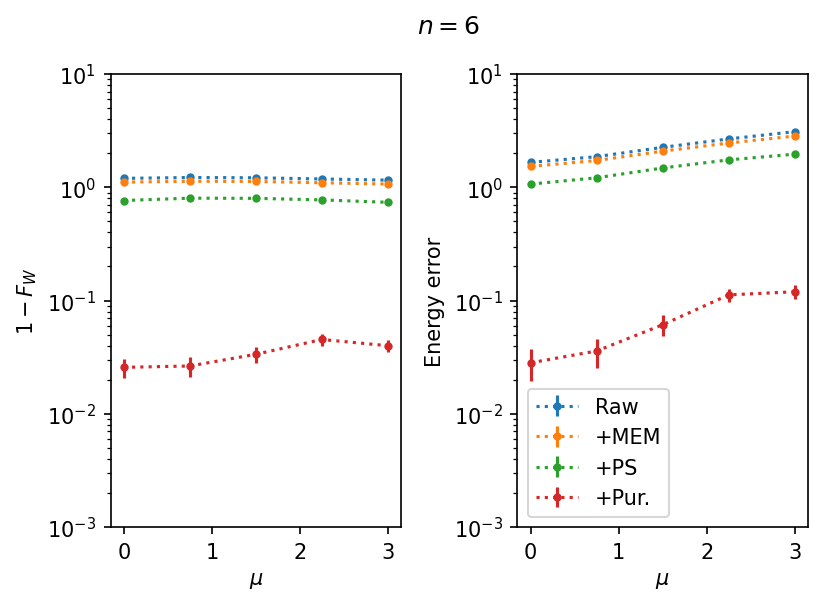

In [9]:
# plot fidelity witness and average energy error
# dd_sequence = None
dd_sequence = 'XY4pm'

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi)
fig.subplots_adjust(wspace=0.4)

values, stddev = fidelity_witness_avg[dd_sequence]['raw']
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt=".:",
    label="Raw",
)
values, stddev = fidelity_witness_avg[dd_sequence]['mem']
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt=".:",
    label="+MEM",
)
values, stddev = fidelity_witness_avg[dd_sequence]['ps']
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt=".:",
    label="+PS",
)
values, stddev = fidelity_witness_avg[dd_sequence]['pur']
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt=".:",
    label="+Pur.",
)
ax1.set_xlabel(r"$\mu$")
ax1.set_ylabel(r"$1 - F_W$")
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 10)

values, stddev = energy_error[dd_sequence]['raw']
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt=".:",
    label="Raw",
)
values, stddev = energy_error[dd_sequence]['mem']
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt=".:",
    label="+MEM",
)
values, stddev = energy_error[dd_sequence]['ps']
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt=".:",
    label="+PS",
)
values, stddev = energy_error[dd_sequence]['pur']
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt=".:",
    label="+Pur.",
)
ax2.set_xlabel(r"$\mu$")
ax2.set_ylabel(r"Energy error")
ax2.set_yscale('log')
ax2.set_ylim(1e-3, 10)
ax2.legend()
fig.suptitle(fr"$n = {params.n_modes}$")

data.add_figures(fig, 'fidelity_witness', overwrite=True)
plt.savefig(f'{PLOT_DIR}/fidelity_witness_dd-{dd_sequence}.{filetype}')
plt.show()

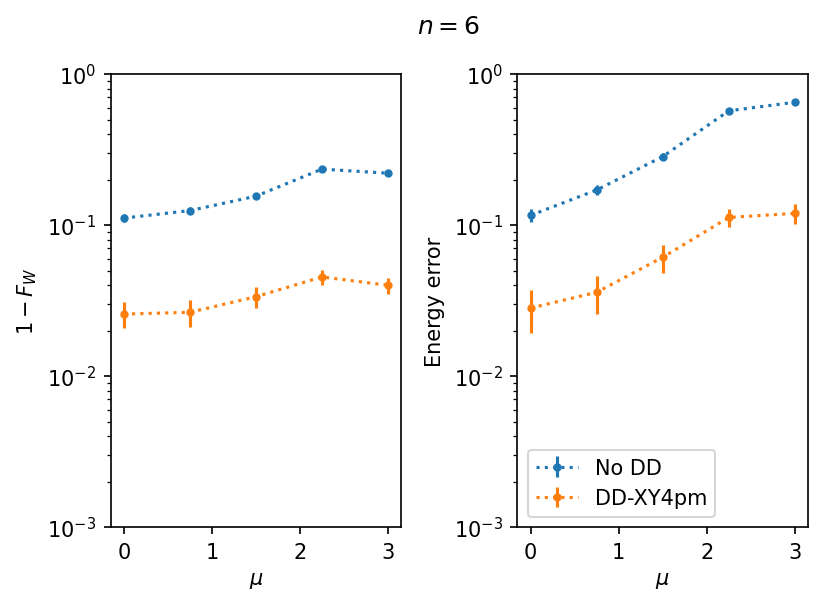

In [8]:
# plot fidelity witness and average energy error, dd vs no dd
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi)
fig.subplots_adjust(wspace=0.4)

values, stddev = fidelity_witness_avg[None]['pur']
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt=".:",
    label="No DD",
)
values, stddev = fidelity_witness_avg[dd_sequence]['pur']
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt=".:",
    label="DD-XY4pm",
)
ax1.set_xlabel(r"$\mu$")
ax1.set_ylabel(r"$1 - F_W$")
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1)

values, stddev = energy_error[None]['pur']
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt=".:",
    label="No DD",
)
values, stddev = energy_error[dd_sequence]['pur']
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt=".:",
    label="DD-XY4pm",
)
ax2.set_xlabel(r"$\mu$")
ax2.set_ylabel(r"Energy error")
ax2.set_yscale('log')
ax2.set_ylim(1e-3, 1)
ax2.legend()
fig.suptitle(fr"$n = {params.n_modes}$")

data.add_figures(fig, 'fidelity_witness_dd', overwrite=True)
plt.savefig(f'{PLOT_DIR}/fidelity_witness_dd_compare.{filetype}')
plt.show()

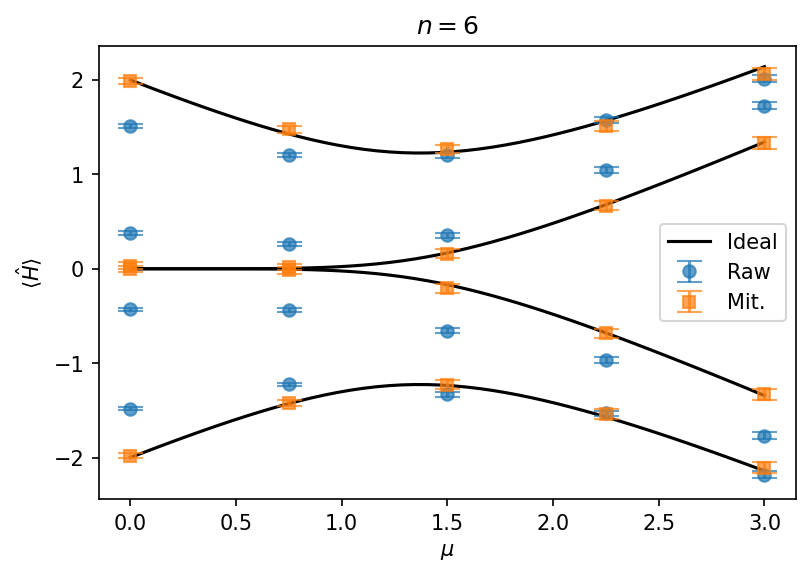

In [9]:
# plot BdG energies
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

for i, energies in enumerate(bdg_energy_exact[0]):
    ax.plot(
        bdg_energy_exact[1],
        energies,
        color='black',
        label=None if i else 'Ideal'
    )

threshold = len(bdg_energy[dd_sequence]['raw'][0]) // 2
raw_values, raw_stddev = bdg_energy[dd_sequence]['raw']
mit_values, mit_stddev = bdg_energy[dd_sequence]['pur']

for i in range(threshold):
    error1 = ax.errorbar(
        params.chemical_potential_values,
        raw_values[i],
        yerr=2 * raw_stddev[i],
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label=None if i else 'Raw'
    )
    ax.errorbar(
        params.chemical_potential_values,
        raw_values[threshold + i],
        yerr=2 * raw_stddev[threshold + i],
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
    )
    error2 = ax.errorbar(
        params.chemical_potential_values,
        mit_values[i],
        yerr=2 * mit_stddev[i],
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label=None if i else 'Mit.'
    )
    ax.errorbar(
        params.chemical_potential_values,
        mit_values[threshold + i],
        yerr=2 * mit_stddev[threshold + i],
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle \hat{H} \rangle$")
ax.legend(loc='right')
ax.set_title(fr"$n = {params.n_modes}$")

data.add_figures(fig, 'bdg_energy', overwrite=True)
plt.savefig(f'{PLOT_DIR}/bdg_energy_dd-{dd_sequence}.{filetype}')

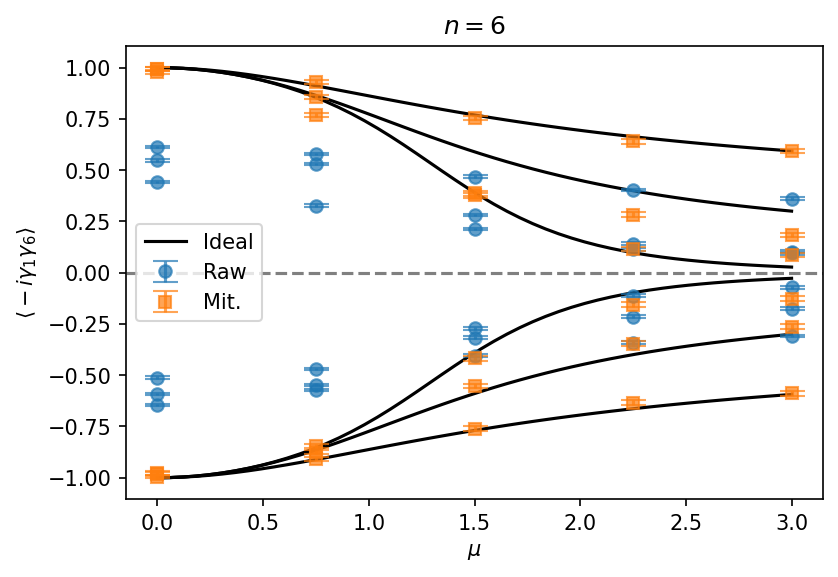

In [10]:
# plot edge correlation
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

for occupied_orbitals, (values, xvals) in edge_correlation_exact.items():
    ax.plot(xvals,
            values,
            color="black",
            label="Ideal" if not occupied_orbitals else None,)

for occupied_orbitals, (values, stddevs) in edge_correlation[dd_sequence]['raw'].items():
    ax.errorbar(
        params.chemical_potential_values,
        values,
        yerr=2 * np.array(stddevs),
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (values, stddevs) in edge_correlation[dd_sequence]['pur'].items():
    ax.errorbar(
        params.chemical_potential_values,
        values,
        yerr=2 * np.array(stddevs),
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="Mit." if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_6 \rangle$")
ax.axhline([0], color='gray', linestyle='--')
ax.legend(loc='center left')
ax.set_title(fr"$n = {params.n_modes}$")

data.add_figures(fig, 'edge_correlation', overwrite=True)
plt.savefig(f'{PLOT_DIR}/edge_correlation_dd-{dd_sequence}.{filetype}')
plt.show()

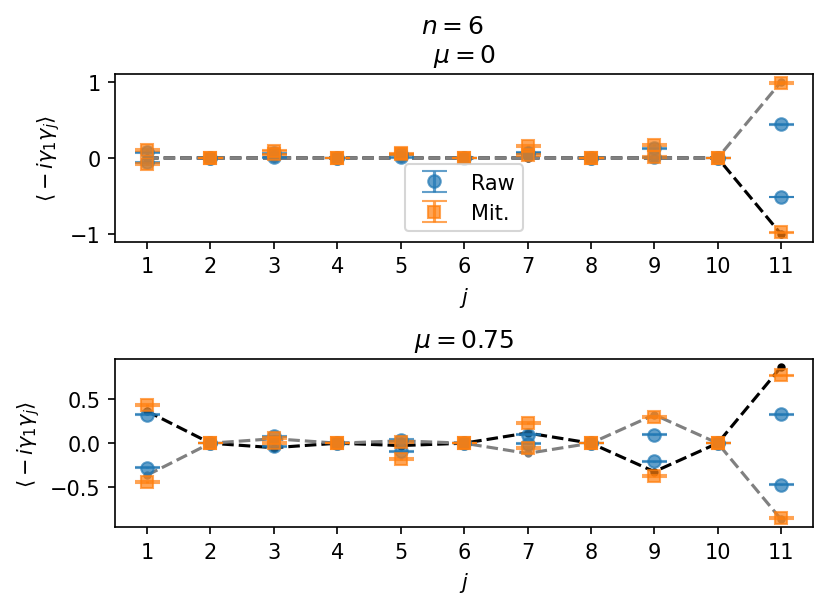

In [11]:
# plot site correlation
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

xvals = range(1, 2 * params.n_modes)
occupied_orbitals_to_plot = params.occupied_orbitals_list[2:4]
fig, axes = plt.subplots(2, 1, dpi=dpi)
fig.subplots_adjust(hspace=0.7)
for index, (ax, chemical_potential) in enumerate(zip(axes, params.chemical_potential_values[:2])):
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        site_correlations = site_correlation_exact[chemical_potential, occupied_orbitals]
        ax.plot(
            xvals,
            site_correlations,
            '.--',
            color="black" if not i else "gray",
            label="Ideal" if not occupied_orbitals else None
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation[dd_sequence]['raw'][chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='o',
            capsize=capsize,
            color=colors[0],
            alpha=0.7,
            label=None if i else 'Raw'
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation[dd_sequence]['pur'][chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='s',
            capsize=capsize,
            color=colors[1],
            alpha=0.7,
            label=None if i else 'Mit.'
        )
    ax.set_xlabel(r"$j$")
    ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_j \rangle$")
    ax.set_xticks(xvals)
    if index == 0:
        ax.legend()
    ax.set_title(fr"$\mu={chemical_potential}$")

fig.suptitle(fr"$n = {params.n_modes}$")
data.add_figures(fig, f'site_correlation', overwrite=True)
plt.savefig(f'{PLOT_DIR}/site_correlation_dd-{dd_sequence}.{filetype}')
plt.show()

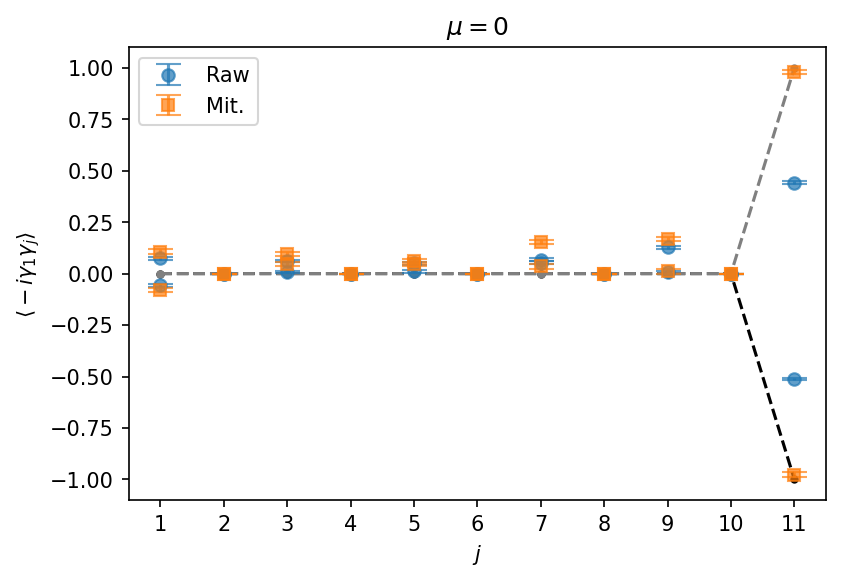

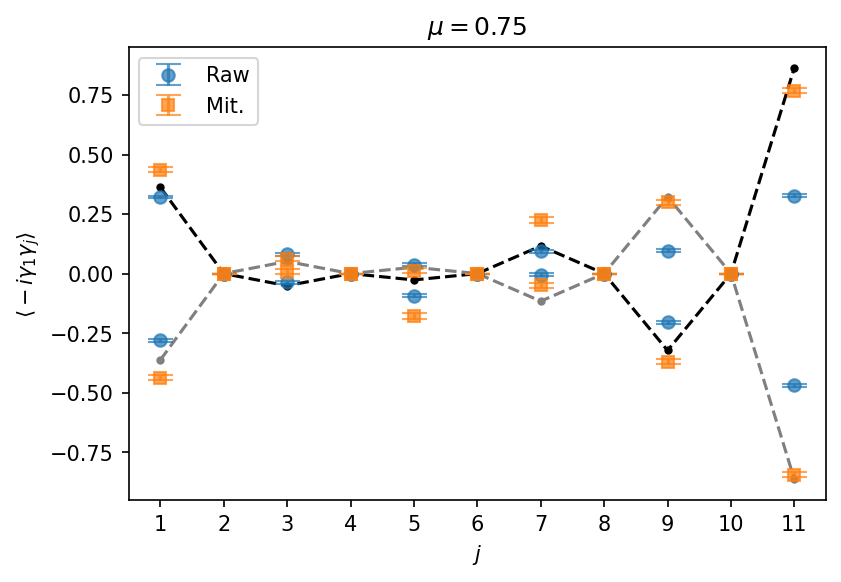

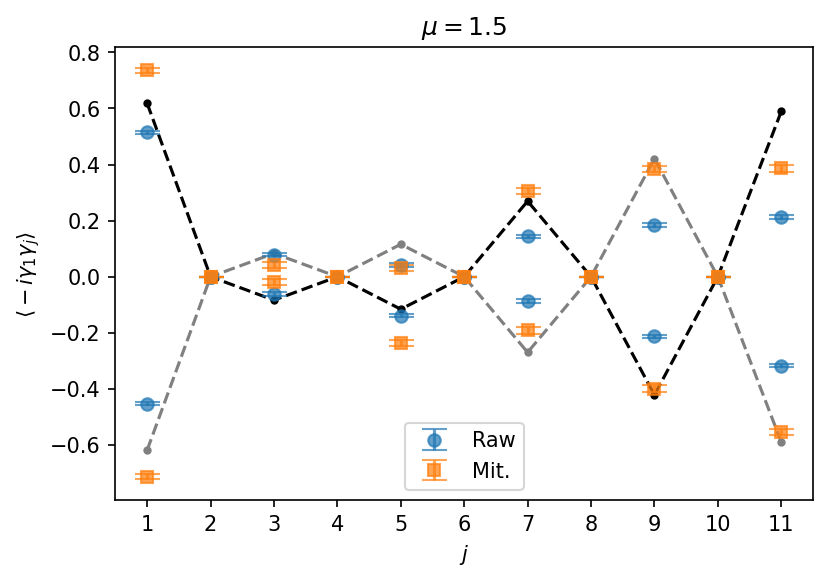

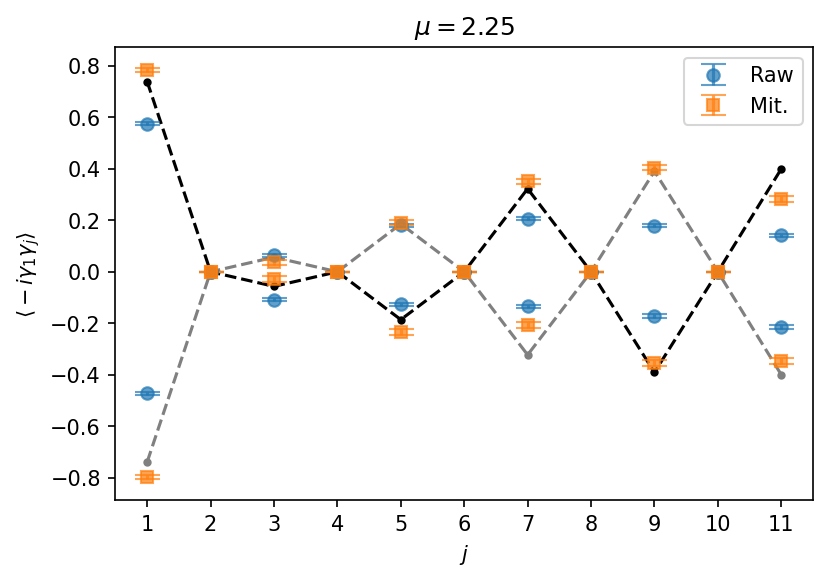

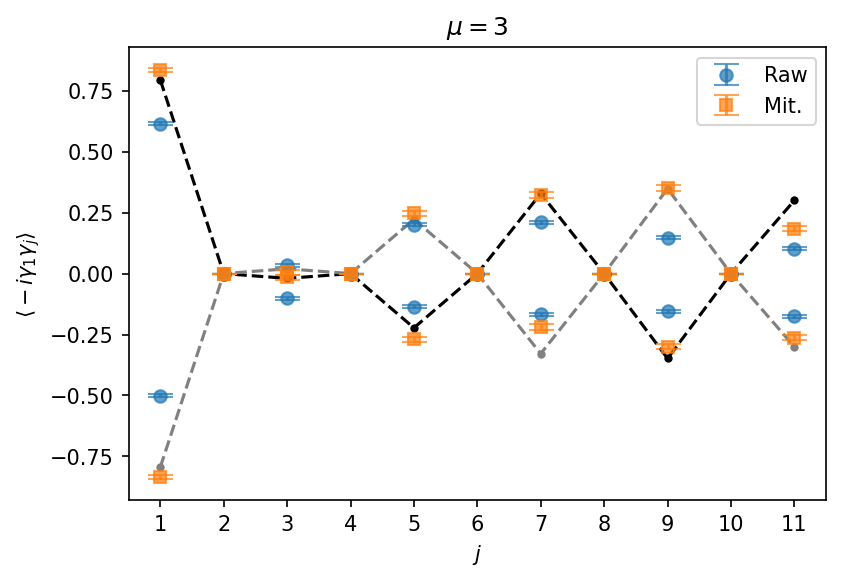

In [12]:
# plot site correlation
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

xvals = range(1, 2 * params.n_modes)
occupied_orbitals_to_plot = params.occupied_orbitals_list[2:4]
for chemical_potential in params.chemical_potential_values:
    fig, ax = plt.subplots(dpi=dpi)
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        site_correlations = site_correlation_exact[chemical_potential, occupied_orbitals]
        ax.plot(
            xvals,
            site_correlations,
            '.--',
            color="black" if not i else "gray",
            label="Ideal" if not occupied_orbitals else None
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation[dd_sequence]['raw'][chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='o',
            capsize=capsize,
            color=colors[0],
            alpha=0.7,
            label=None if i else 'Raw'
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation[dd_sequence]['pur'][chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='s',
            capsize=capsize,
            color=colors[1],
            alpha=0.7,
            label=None if i else 'Mit.'
        )
    ax.set_xlabel(r"$j$")
    ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_j \rangle$")
    ax.set_xticks(xvals)
    ax.legend()
    ax.set_title(fr"$\mu={chemical_potential}$")

    data.add_figures(fig, f'site_correlation_mu{chemical_potential}_dd-{dd_sequence}', overwrite=True)
    plt.savefig(f'{PLOT_DIR}/site_correlation_mu{chemical_potential}_dd-{dd_sequence}.{filetype}')
    plt.show()

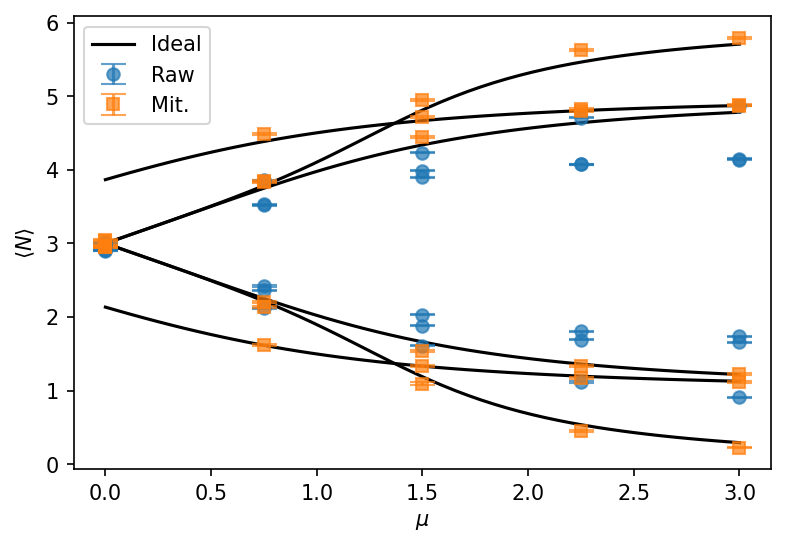

In [13]:
# plot number
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

for occupied_orbitals, (numbers, xvals) in number_exact.items():
    ax.plot(
        xvals,
        numbers,
        label="Ideal" if not occupied_orbitals else None,
        color="black",
    )

for occupied_orbitals, (numbers, stddevs) in number[dd_sequence]['raw'].items():
    ax.errorbar(
        params.chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (numbers, stddevs) in number[dd_sequence]['pur'].items():
    ax.errorbar(
        params.chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="Mit." if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.legend()

data.add_figures(fig, 'number', overwrite=True)
plt.savefig(f'{PLOT_DIR}/number_dd-{dd_sequence}.{filetype}')
plt.show()

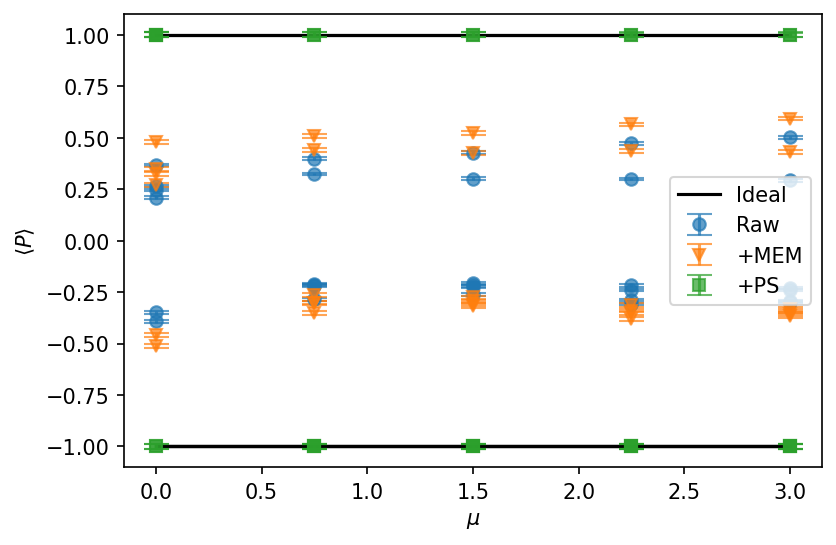

In [14]:
# plot parity
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

for occupied_orbitals, (parities, xvals) in parity_exact.items():
    ax.plot(xvals, parities, label="Ideal" if not occupied_orbitals else None,
            color="black")

for occupied_orbitals, (parities, stddevs) in parity[dd_sequence]['raw'].items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        params.chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (parities, stddevs) in parity[dd_sequence]['mem'].items():
    ax.errorbar(
        params.chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt='v',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="+MEM" if not occupied_orbitals else None,
    )
for occupied_orbitals, (parities, stddevs) in parity[dd_sequence]['ps'].items():
    ax.errorbar(
        params.chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt='s',
        capsize=capsize,
        color=colors[2],
        alpha=0.7,
        label="+PS" if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity', overwrite=True)
plt.savefig(f'{PLOT_DIR}/parity.{filetype}')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


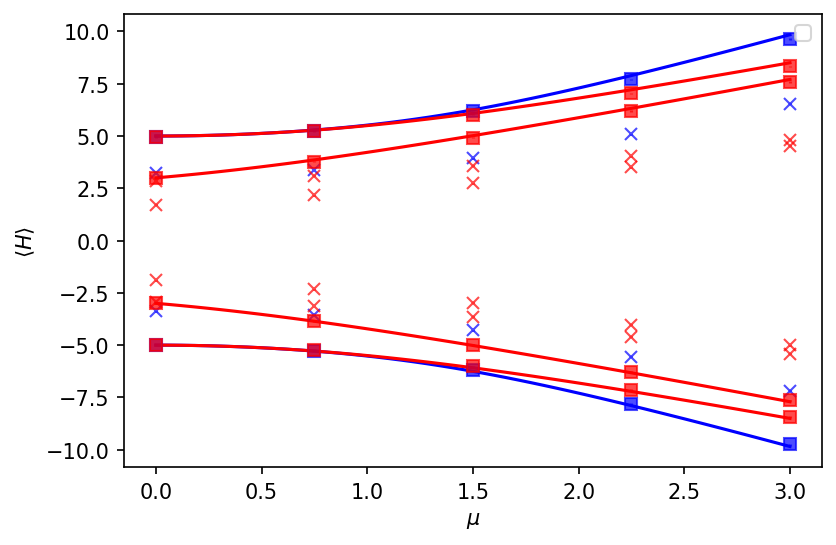

In [13]:
# plot energy
fig, ax = plt.subplots(dpi=dpi)

for occupied_orbitals, (energies, xvals) in energy_exact.items():
    ax.plot(
        xvals, energies,
        # label = "Ideal" if not i else None,
        color="red" if len(occupied_orbitals) % 2 else "blue"
    )
for occupied_orbitals, (energies, stddevs) in energy[dd_sequence]['raw'].items():
    ax.errorbar(
        params.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x",
        # label="Raw" if not i else None,
        color="red" if len(occupied_orbitals) % 2 else "blue",
        alpha=0.7,
    )
for occupied_orbitals, (energies, stddevs) in energy[dd_sequence]['pur'].items():
    ax.errorbar(
        params.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s",
        # label = "Mit." if not i else None,
        color = "red" if len(occupied_orbitals) % 2 else "blue",
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.legend()

data.add_figures(fig, 'energy', overwrite=True)
plt.savefig(f'{PLOT_DIR}/energy.{filetype}')
plt.show()